Importing Dependencies

In [1]:
!pip3 install --upgrade pip

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [6]:
!pip3 install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.5/228.5 MB 1.7 MB/s eta 0:00:0000:0100:04
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.4 MB/s eta 0:00:0000:0100:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.1 MB/s eta 0:00:0000:0100:01
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.4 MB/s eta 0:00:0000:01
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cac

In [3]:
!pip3 install opencv-python matplotlib

  Using cached opencv_python-4.6.0.66-cp36-abi3-macosx_10_15_x86_64.whl (46.4 MB)


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [18]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [19]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [ ]:
POS_PATH

Collecting data

In [ ]:
#http://vis-www.cs.umass.edu/lfw/
!tar -xf lfw.tar

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [12]:
import uuid

In [20]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [16]:
frame.shape

(250, 250, 3)

Load and Preprocess image

In [25]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(200)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(200)

In [26]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/a2179d40-14c9-11ed-9f28-acde48001122.jpg'


In [27]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [28]:
img = preprocess('data/anchor/a2179d40-14c9-11ed-9f28-acde48001122.jpg')

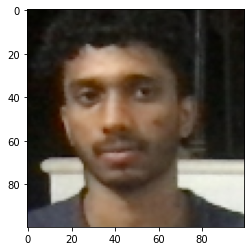

In [30]:
plt.imshow(img)

In [31]:
#creating positive and negative classes
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [32]:
samples = data.as_numpy_iterator()

In [36]:
#positive and negative classes look like this
example = samples.next()

Train and Test partition

In [37]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [38]:
res = preprocess_twin(*example)

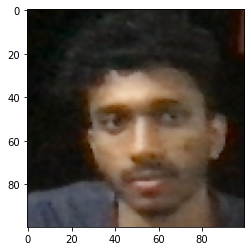

In [39]:
plt.imshow(res[0])

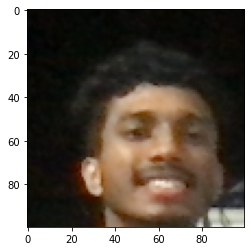

In [40]:
plt.imshow(res[1])

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

TypeError: in user code:

    File "/var/folders/r7/gsmc7wxj3dqg05vpsdj97_l00000gn/T/ipykernel_23034/3087020015.py", line 2, in preprocess_twin  *
        return(preprocess(input_img), preprocess(validation_img), label)
    File "/var/folders/r7/gsmc7wxj3dqg05vpsdj97_l00000gn/T/ipykernel_23034/788527913.py", line 4, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [44]:
samples = data.as_numpy_iterator()

In [45]:
samples.next()

(array([[[0.03235294, 0.04411765, 0.01666667],
         [0.02745098, 0.03921569, 0.01176471],
         [0.03137255, 0.04313726, 0.01568628],
         ...,
         [0.02720588, 0.03504902, 0.02328431],
         [0.02352941, 0.03137255, 0.01960784],
         [0.00784314, 0.02745098, 0.01176471]],
 
        [[0.03897059, 0.04289216, 0.02328431],
         [0.04068628, 0.04534314, 0.02573529],
         [0.03235294, 0.03848039, 0.02107843],
         ...,
         [0.03137255, 0.03921569, 0.02941176],
         [0.03137255, 0.03921569, 0.02941176],
         [0.02156863, 0.04019608, 0.02745098]],
 
        [[0.0379902 , 0.03602941, 0.0252451 ],
         [0.03529412, 0.03627451, 0.0254902 ],
         [0.02843137, 0.02867647, 0.02009804],
         ...,
         [0.03529412, 0.04313726, 0.03921569],
         [0.03529412, 0.04313726, 0.03921569],
         [0.03431373, 0.05      , 0.04607843]],
 
        ...,
 
        [[0.15416667, 0.18357843, 0.22769608],
         [0.15686275, 0.18651961, 0.22794

In [46]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [47]:
train_sample= train_data.as_numpy_iterator().next()

In [50]:
len(train_sample[0])

16

In [51]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Building the deep model

In [52]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [54]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [55]:
l1 = L1Dist()

In [57]:
#l1(anchor_embedding, validation_embedding)

Making siamese model

In [58]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')